#import data

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import numpy as np
from sklearn.model_selection import train_test_split

import random
import matplotlib.pyplot as plt

from sklearn import neighbors, datasets
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Evaluation

In [3]:
from sklearn.metrics import mean_squared_error, r2_score

def get_scores(y_true, y_pred):
  rmse = mean_squared_error(y_true, y_pred)**0.5
  r2 = r2_score(y_true, y_pred)

  return rmse, r2

#Predicting member trips

## dataset

In [4]:
X_train = pd.read_csv('/content/drive/MyDrive/CIV1498 Final Project/Other/X_train.csv')
X_val = pd.read_csv('/content/drive/MyDrive/CIV1498 Final Project/Other/X_val.csv')
X_test = pd.read_csv('/content/drive/MyDrive/CIV1498 Final Project/Other/X_test.csv')
y_train = pd.read_csv('/content/drive/MyDrive/CIV1498 Final Project/Other/y_train.csv')
y_val = pd.read_csv('/content/drive/MyDrive/CIV1498 Final Project/Other/y_val.csv')
y_test = pd.read_csv('/content/drive/MyDrive/CIV1498 Final Project/Other/y_test.csv')

In [5]:
#day not affect much. delete this features

header = ['Temp (°C)', 'Rel Hum (%)', 'Wind Dir (10s deg)', 'Wind Spd (km/h)',
       'Visibility (km)', 'Stn Press (kPa)', 'Year_2017', 'Year_2018',
       'Year_2019', 'Year_2020', 'Year_2021', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9',
       'Month_10', 'Month_11', 'Month_12', 'period_1',
       'period_2', 'period_3', 'period_4', 'period_5', 'Weekday_0',
       'Weekday_1', 'Weekday_2', 'Weekday_3', 'Weekday_4', 'Weekday_5',
       'Weekday_6', 'is_holiday_False', 'is_holiday_True', 'is_weekend_False',
       'is_weekend_True', 'Weather_Clear', 'Weather_Fog',
       'Weather_Precipitation']

X_train = X_train[header]
X_val = X_val[header]
X_test = X_test[header]
y_train = y_train['total casual']
y_val = y_val['total casual']
y_test = y_test['total casual']

##Baseline model - predicting with only the temperature

In [6]:
model = LinearRegression(fit_intercept = True)
model.fit(np.array(X_train['Temp (°C)']).reshape(-1, 1), y_train)

y_train_pred = model.predict(np.array(X_train['Temp (°C)']).reshape(-1, 1))
y_val_pred = model.predict(np.array(X_val['Temp (°C)']).reshape(-1, 1))
y_test_pred = model.predict(np.array(X_test['Temp (°C)']).reshape(-1, 1))

base_train_rmse, base_train_r2 = get_scores(y_train_pred, y_train)[0], get_scores(y_train_pred, y_train)[1]
base_val_rmse, base_val_r2 = get_scores(y_val_pred, y_val)[0], get_scores(y_val_pred, y_val)[1]


print('Training RMSE: {}\nTraining R2: {}'.format(get_scores(y_train_pred, y_train)[0], get_scores(y_train_pred, y_train)[1]))
print('Validation RMSE: {}\nValidation R2: {}'.format(get_scores(y_val_pred, y_val)[0], get_scores(y_val_pred, y_val)[1]))
print('Test RMSE: {}\nTest R2: {}'.format(get_scores(y_test_pred, y_test)[0], get_scores(y_test_pred, y_test)[1]))

Training RMSE: 550.0108026589685
Training R2: -2.230514657370424
Validation RMSE: 545.885144891992
Validation R2: -2.3641508213327813
Test RMSE: 525.6285406385338
Test R2: -1.969851842483318


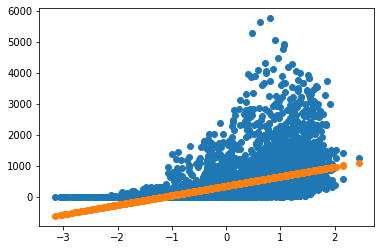

In [ ]:
plt.scatter(np.array(X_train['Temp (°C)']).reshape(-1, 1), y_train)
plt.scatter(np.array(X_train['Temp (°C)']).reshape(-1, 1), y_train_pred)

##Linear Regression-Predicting with trip and weather data

In [7]:
model = LinearRegression(fit_intercept= True)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

lr_train_rmse, lr_train_r2 = get_scores(y_train_pred, y_train)[0], get_scores(y_train_pred, y_train)[1]
lr_val_rmse, lr_val_r2 = get_scores(y_val_pred, y_val)[0], get_scores(y_val_pred, y_val)[1]


print('Training RMSE: {}\nTraining R2: {}'.format(get_scores(y_train_pred, y_train)[0], get_scores(y_train_pred, y_train)[1]))
print('Validation RMSE: {}\nValidation R2: {}'.format(get_scores(y_val_pred, y_val)[0], get_scores(y_val_pred, y_val)[1]))
print('Test RMSE: {}\nTest R2: {}'.format(get_scores(y_test_pred, y_test)[0], get_scores(y_test_pred, y_test)[1]))

Training RMSE: 440.7814782734439
Training R2: 0.03751663159903518
Validation RMSE: 437.5676945749231
Validation R2: 0.024882536438290304
Test RMSE: 419.71066702573034
Test R2: 0.07708227030427495


##KNN - Predicting with Weather and trip Data

In [8]:
#select k
param_test1 = {'n_neighbors': range(1, 21)}
gsearch1 = GridSearchCV(estimator = KNeighborsRegressor(), param_grid = param_test1, cv = 5)
gsearch1.fit(X_train, y_train)
k = gsearch1.best_params_['n_neighbors']

#get the maximum cross validation accuracy and corresponding k value
#best k = 10
print("Best k: ", k)


#train the actual model with the best parameters
model = KNeighborsRegressor(n_neighbors = k)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

knn_train_rmse, knn_train_r2 = get_scores(y_train_pred, y_train)[0], get_scores(y_train_pred, y_train)[1]
knn_val_rmse, knn_val_r2 = get_scores(y_val_pred, y_val)[0], get_scores(y_val_pred, y_val)[1]

print('Training RMSE: {}\nTraining R2: {}'.format(get_scores(y_train_pred, y_train)[0], get_scores(y_train_pred, y_train)[1]))
print('Validation RMSE: {}\nValidation R2: {}'.format(get_scores(y_val_pred, y_val)[0], get_scores(y_val_pred, y_val)[1]))
print('Test RMSE: {}\nTest R2: {}'.format(get_scores(y_test_pred, y_test)[0], get_scores(y_test_pred, y_test)[1]))

Best k:  10
Training RMSE: 294.57319358445005
Training R2: 0.6259426478776521
Validation RMSE: 332.41854883893626
Validation R2: 0.4685991835111475
Test RMSE: 310.73265694254223
Test R2: 0.5342176848696629


##Decision Tree - Predicting with trip and weather data

In [9]:
#select maximum depth of a tree
param_test1 = {'max_depth': range(1, 30), 'min_samples_split': range(2, 20)}
gsearch1 = GridSearchCV(estimator = DecisionTreeRegressor(random_state = 0, min_samples_leaf = 1), param_grid = param_test1, cv = 5)
gsearch1.fit(X_train, y_train)
d = gsearch1.best_params_['max_depth']

#select min_sample split and min_samples_leaf
param_test2 = {'min_samples_split': range(2, 20), 'min_samples_leaf': range(1,20)}
gsearch2 = GridSearchCV(estimator = DecisionTreeRegressor(max_depth = d, random_state = 0), param_grid = param_test2, cv = 5)
gsearch2.fit(X_train, y_train)
s = gsearch2.best_params_['min_samples_split']
l = gsearch2.best_params_['min_samples_leaf']

#print hyperparameter results
#best d = 9, best s = 19, best l = 2
print("Best tree depth: ", d)
print("Best min sample split: ", s)
print("Best min sample leaf: ", l)

#train the actual model with the optimum parameters
model = DecisionTreeRegressor(random_state = 0, max_depth = d, min_samples_split = s, min_samples_leaf = l)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

dt_train_rmse, dt_train_r2 = get_scores(y_train_pred, y_train)[0], get_scores(y_train_pred, y_train)[1]
dt_val_rmse, dt_val_r2 = get_scores(y_val_pred, y_val)[0], get_scores(y_val_pred, y_val)[1]

print('Training RMSE: {}\nTraining R2: {}'.format(get_scores(y_train_pred, y_train)[0], get_scores(y_train_pred, y_train)[1]))
print('Validation RMSE: {}\nValidation R2: {}'.format(get_scores(y_val_pred, y_val)[0], get_scores(y_val_pred, y_val)[1]))
print('Test RMSE: {}\nTest R2: {}'.format(get_scores(y_test_pred, y_test)[0], get_scores(y_test_pred, y_test)[1]))

Best tree depth:  9
Best min sample split:  19
Best min sample leaf:  2
Training RMSE: 215.0309554749811
Training R2: 0.867858665324438
Validation RMSE: 308.01511462041657
Validation R2: 0.7388559194977874
Test RMSE: 241.86594829675866
Test R2: 0.8317785585564734


##Random Forest - Predicting with weather and trip data

In [ ]:
#select the number of trees
param_test2 = {'n_estimators': range(1, 51)}
gsearch2 = GridSearchCV(estimator = RandomForestRegressor(max_depth = 10, random_state = 0, min_samples_leaf = 1, min_samples_split = 2), param_grid = param_test2, cv = 5)
gsearch2.fit(X_train, y_train)
n = gsearch2.best_params_['n_estimators']
print("Best number of trees: ", n)

Best number of trees:  46


In [ ]:
n = 46
#select maximum depth of a tree
param_test2 = {'max_depth': range(1, 21)}
gsearch2 = GridSearchCV(estimator = RandomForestRegressor(n_estimators = n, random_state = 0, min_samples_leaf = 1, min_samples_split = 2), param_grid = param_test2, cv = 5)
gsearch2.fit(X_train, y_train)
d = gsearch2.best_params_['max_depth']
print("Best tree depth: ", d)

Best tree depth:  14


In [ ]:
n = 46
d = 14

#select min_sample split
param_test3 = {'min_samples_split': range(2, 11)}
gsearch3 = GridSearchCV(estimator = RandomForestRegressor(n_estimators = n, max_depth = d, random_state = 0, min_samples_leaf = 1), param_grid = param_test3, cv = 5)
gsearch3.fit(X_train, y_train)
s = gsearch3.best_params_['min_samples_split']
print("Best min sample split: ", s)

Best min sample split:  2


In [ ]:
n = 46
d = 14
s = 2

#select min_samples_leaf
param_test4 = {'min_samples_leaf': range(1,11)}
gsearch4 = GridSearchCV(estimator = RandomForestRegressor(n_estimators = n, max_depth = d, random_state = 0, min_samples_split = s), param_grid = param_test4, cv = 5)
gsearch4.fit(X_train, y_train)
l = gsearch4.best_params_['min_samples_leaf']
print("Best min sample leaf: ", l)

Best min sample leaf:  1


In [10]:
n = 45
d = 20
s = 2
l = 1

#45, 20, 2, 1
#train the model with the optimum hyper-parameters
model = RandomForestRegressor(random_state = 0, n_estimators = n, max_depth = d, min_samples_split = s, min_samples_leaf = l)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

rf_train_rmse, rf_train_r2 = get_scores(y_train_pred, y_train)[0], get_scores(y_train_pred, y_train)[1]
rf_val_rmse, rf_val_r2 = get_scores(y_val_pred, y_val)[0], get_scores(y_val_pred, y_val)[1]


print('Training RMSE: {}\nTraining R2: {}'.format(get_scores(y_train_pred, y_train)[0], get_scores(y_train_pred, y_train)[1]))
print('Validation RMSE: {}\nValidation R2: {}'.format(get_scores(y_val_pred, y_val)[0], get_scores(y_val_pred, y_val)[1]))
print('Test RMSE: {}\nTest R2: {}'.format(get_scores(y_test_pred, y_test)[0], get_scores(y_test_pred, y_test)[1]))

Training RMSE: 86.74478049035025
Training R2: 0.9794374743923602
Validation RMSE: 241.69544963720935
Validation R2: 0.8321481871632707
Test RMSE: 191.9262615348358
Test R2: 0.8844296627733886


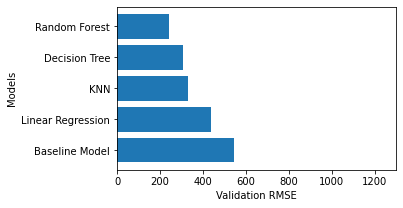

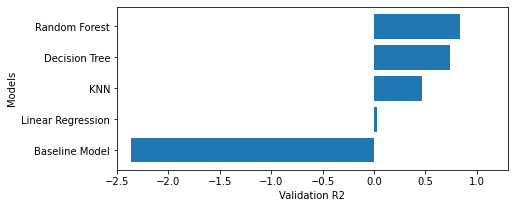

In [11]:
import matplotlib.pyplot as plt
   
models = ['Baseline Model','Linear Regression','KNN','Decision Tree','Random Forest']
rmse_train = [base_train_rmse, lr_train_rmse, knn_train_rmse, dt_train_rmse, rf_train_rmse]
rmse_val = [base_val_rmse, lr_val_rmse, knn_val_rmse, dt_val_rmse, rf_val_rmse]
r2_train = [base_train_r2, lr_train_r2, knn_train_r2, dt_train_r2, rf_train_r2]
r2_val = [base_val_r2, lr_val_r2, knn_val_r2, dt_val_r2, rf_val_r2]

plt.figure(figsize = (5, 3))
plt.barh(models,rmse_val)
plt.ylabel('Models')
plt.xlabel('Validation RMSE')
plt.xlim(0, 1300)
plt.show()

plt.figure(figsize = (7, 3))
plt.barh(models,r2_val)
plt.ylabel('Models')
plt.xlabel('Validation R2')
plt.xlim(-2.5, 1.3)
plt.show()